# IRMDP: Homework 6.2 and 6.3

Implementation is according to [testSensitivity.py](https://github.com/sschlenkrich/QuantLibPython/blob/master/testSensitivity.py).

## Importing of classes and necessary setting as in testSensitivity.py

In [1]:
import sys, os, io, copy, time
if locals().get('__file__'):
    sys.path.append(os.path.join(os.path.dirname(__file__),'QuantLibWrapper'))
else:
    sys.path.append(os.path.join(os.getcwd(),'QuantLibWrapper'))
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from itertools import product

import QuantLib as ql

from QuantLibWrapper import YieldCurve, Swap, Swaption, createSwaption, \
    HullWhiteModel, HullWhiteModelFromSwaption, BermudanSwaption, PDESolver, \
    DensityIntegrationWithBreakEven, CubicSplineExactIntegration, \
    SimpsonIntegration, HermiteIntegration
from QuantLibWrapper.YieldCurve import YieldCurve

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
terms = [    '1y',    '2y',    '3y',    '4y',    '5y',    '6y',    '7y',    '8y',    '9y',   '10y',   '12y',   '15y',   '20y',   '25y',   '30y' ] 
rates = [ 2.70e-2, 2.75e-2, 2.80e-2, 3.00e-2, 3.36e-2, 3.68e-2, 3.97e-2, 4.24e-2, 4.50e-2, 4.75e-2, 4.75e-2, 4.70e-2, 4.50e-2, 4.30e-2, 4.30e-2 ] 

if False:
    terms = [ '30y'   ]  # flat curve
    rates = [ 5.00e-2 ] 
rates2 = [ r+0.005 for r in rates ]

discCurve = YieldCurve(terms,rates)
projCurve = YieldCurve(terms,rates)

a = 0.03 # mean reversion
vol = 0.01
h = 1.0e-12

swaptionStrike = createSwaption('10y','10y',discCurve,projCurve).fairRate() \
                 + vol * np.sqrt(10.0) * np.sqrt(3.0)
swaptionStrike = 0.1048
print('swaptionStrike = ' + str(swaptionStrike))

swaptionStrike = 0.1048


## Computation

In [3]:
def compute_integration(method,n_grid_points=101,lambda_std_devs=5,hs=[10.0**(-k) for k in range(3,18)]):
    res = []
    assert method in [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration], 'the method is not allowed'
    if isinstance(n_grid_points,int): n_grid_points = [n_grid_points]
    if isinstance(lambda_std_devs,int): lambda_std_devs = [lambda_std_devs]
    args = pd.DataFrame(list(product(n_grid_points,lambda_std_devs,hs)), columns=['n_grid_points','lambda_std_devs','h'])
    for _,arg in args.iterrows():
        h = arg['h']
        n = arg['n_grid_points']
        l = arg['lambda_std_devs']
        print('h = ' + str(h))
        # swaptions
        s0 = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol)
        sp = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol+h)
        sm = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol-h)
        # models
        h0 = HullWhiteModelFromSwaption(s0,a)
        hp = HullWhiteModelFromSwaption(sp,a)
        hm = HullWhiteModelFromSwaption(sm,a)
        # Berms via PDE
        p0 = BermudanSwaption([s0],a,model=h0,method=PDESolver(h0,n,3.0,0.5,1.0/12.0))
        pp = BermudanSwaption([sp],a,model=hp,method=PDESolver(hp,n,3.0,0.5,1.0/12.0))
        pm = BermudanSwaption([sm],a,model=hm,method=PDESolver(hm,n,3.0,0.5,1.0/12.0))
        # Berms via density integration
        i10 = BermudanSwaption([s0],a,model=h0,method=method(h0,n,l))
        i1p = BermudanSwaption([sp],a,model=hp,method=method(hp,n,l))
        i1m = BermudanSwaption([sm],a,model=hm,method=method(hm,n,l))
        
        i20 = BermudanSwaption([s0],a,model=h0,method=DensityIntegrationWithBreakEven(method(h0,n,l)))
        i2p = BermudanSwaption([sp],a,model=hp,method=DensityIntegrationWithBreakEven(method(hp,n,l)))
        i2m = BermudanSwaption([sm],a,model=hm,method=DensityIntegrationWithBreakEven(method(hm,n,l)))

        res.append([ h, n,l,s0.vega(),
            s0.npv(),            sp.npv(),            sm.npv(),
            s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
            p0.npv(),            pp.npv(),            pm.npv(),
            i10.npv(),            i1p.npv(),            i1m.npv(),
            i20.npv(),            i2p.npv(),            i2m.npv()
        ])
    column = [ 'h', 'n_grid_points', 'lambda_std_devs', 'Vega', 'B0', 'Bp', 'Bm', 'H0', 'Hp', 'Hm','P0','Pp','Pm','I0','Ip','Im','I_be_0', 'I_be_p', 'I_be_m']
    return pd.DataFrame(dict(zip(column,np.array(res).T)))

In [4]:
def compute_integration2(method,n_grid_points=101,lambda_std_devs=5,hs=[10.0**(-k) for k in range(3,18)],
                         break_even=True,non_break_even=True,degree=None,theta=0.5, timeStepSize=1.0/12.0, lambda0N=None):
    res = []
    assert method in [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver], 'the method is not allowed'
    if method == HermiteIntegration:
        assert isinstance(degree,int), 'degree must be integer'
    if isinstance(n_grid_points,int): n_grid_points = [n_grid_points]
    if isinstance(lambda_std_devs,int): lambda_std_devs = [lambda_std_devs]
    args = pd.DataFrame(list(product(n_grid_points,lambda_std_devs,hs)), columns=['n_grid_points','lambda_std_devs','h'])
    for _,arg in args.iterrows():
        h = arg['h']
        n = arg['n_grid_points']
        l = arg['lambda_std_devs']
        print('h = ' + str(h))
        # swaptions
        s0 = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol)
        sp = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol+h)
        sm = createSwaption('10y','10y',discCurve,projCurve,strike=swaptionStrike,normalVolatility=vol-h)
        # models
        h0 = HullWhiteModelFromSwaption(s0,a)
        hp = HullWhiteModelFromSwaption(sp,a)
        hm = HullWhiteModelFromSwaption(sm,a)
        # Berms via density integration
        kwargs = {
            '0':{'hwModel':h0,'nGridPoints':n,'stdDevs':l},
            'p':{'hwModel':hp,'nGridPoints':n,'stdDevs':l},
            'm':{'hwModel':hm,'nGridPoints':n,'stdDevs':l}
        }
        if method.__name__ == 'HermiteIntegration':
            for k,v in kwargs.items():
                v.update({'degree':degree})
        elif method.__name__ == 'PDESolver':
            for k,v in kwargs.items():
                v.update({'theta':theta})
                v.update({'timeStepSize':timeStepSize})
                v.update({'lambda0N':lambda0N})
        if non_break_even:
            i10 = BermudanSwaption([s0],a,model=h0,method=method(**kwargs['0']))
            i1p = BermudanSwaption([sp],a,model=hp,method=method(**kwargs['p']))
            i1m = BermudanSwaption([sm],a,model=hm,method=method(**kwargs['m']))
            res.append([ h, n,l,True, theta,timeStepSize,s0.vega(),
                s0.npv(),            sp.npv(),            sm.npv(),
                s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
                i10.npv(),            i1p.npv(),            i1m.npv()
            ])
        if break_even:
            i20 = BermudanSwaption([s0],a,model=h0,method=DensityIntegrationWithBreakEven(method(**kwargs['0'])))
            i2p = BermudanSwaption([sp],a,model=hp,method=DensityIntegrationWithBreakEven(method(**kwargs['p'])))
            i2m = BermudanSwaption([sm],a,model=hm,method=DensityIntegrationWithBreakEven(method(**kwargs['m'])))
            res.append([ h, n,l,True, theta,timeStepSize,s0.vega(),
                s0.npv(),            sp.npv(),            sm.npv(),
                s0.npvHullWhite(h0), sp.npvHullWhite(hp), sm.npvHullWhite(hm),
                i20.npv(),           i2p.npv(),           i2m.npv()
            ])
    column = [ 'h', 'n_grid_points', 'lambda_std_devs', 'break_even','theta','timeStepSize',
              'Vega', 'B0', 'Bp', 'Bm', 'H0', 'Hp', 'Hm','I0','Ip','Im']
    ret = pd.DataFrame(dict(zip(column,np.array(res).T)))
    ret['density_integration_method'] = method.__name__
    ret['density_integration_method'].astype(str)
    ret['degree'] = 0
    if method.__name__ == 'HermiteIntegration':
        ret['degree'] = degree
    ret['degree'].astype(int)
    ret['lambda0N'] = None
    if method.__name__ == 'PDESolver':
        ret['lambda0N'] = lambda0N
    ret['degree'].astype(int)
    return ret

In [5]:
def compute_integration2_multiple(n_grid_points=[101],lambda_std_devs=[5],hs=[10.0**(-k) for k in range(3,18)],
                                  break_even=True,non_break_even=True,degree=[3],
                                  theta=[0.5],timeStepSize=[1/12],lambda0N=[None],
                                  methods = [SimpsonIntegration,CubicSplineExactIntegration,HermiteIntegration,PDESolver]):
    table = list()
    timetable = []
    if not isinstance(degree,list):
        degree = [degree]
    
    for method in [i for i in methods if i in [SimpsonIntegration,CubicSplineExactIntegration]]:
        start = time.time()
        tmp = compute_integration2(method=method,n_grid_points=n_grid_points,lambda_std_devs=lambda_std_devs,
                                   hs=hs,break_even=break_even,non_break_even=non_break_even)
        end = time.time()
        table.append(tmp)
        timetable.append([method.__name__,None,end-start])
        del tmp
    if HermiteIntegration in methods:
        for d in degree:
            start = time.time()
            tmp = compute_integration2(method=HermiteIntegration,n_grid_points=n_grid_points,
                                       lambda_std_devs=lambda_std_devs,hs=hs,break_even=break_even,degree=d)
            end = time.time()
            table.append(tmp)
            timetable.append(['HermiteIntegration',d,end-start])
            del tmp
    if PDESolver in methods:
        for i in list(product(n_grid_points,lambda_std_devs,hs,theta,timeStepSize,lambda0N)):
            start = time.time()
            tmp = compute_integration2(method=PDESolver,n_grid_points=[i[0]],
                                       lambda_std_devs=[i[1]],hs=[i[2]],break_even=break_even,theta=i[3],timeStepSize=i[4],
                                       lambda0N=i[5])
            end = time.time()
            table.append(tmp)
            timetable.append(['PDESolver',None,end-start])
        del tmp
        
    return pd.concat(table),pd.DataFrame(timetable,columns=['method','degree','comp_time'])

In [6]:
def plotRelativeError(table,id,title=''):
    fig = plt.figure(figsize=(6, 4))
    # upward derivative
    vega = (table[id+'p']-table[id+'0'])/table['h']*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Upward')
    # downward derivative
    vega = (table[id+'0']-table[id+'m'])/table['h']*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Downward')
    # two-sided derivative
    vega = (table[id+'p']-table[id+'m'])/table['h']/2.0*1.0e-4
    relError = abs(vega/table['Vega']-1)
    plt.loglog(table['h'],relError,label='Two-sided')
    # plot properties
    plt.xlabel('shift size h')
    plt.ylabel('|RelError|')
    plt.title(title)
    plt.ylim(1.0e-11,10.0)
    plt.legend()

In [7]:
def plotRelativeError2(table,id,leg1,leg2=None,integration_method=['Two-sided','Upward','Downward'],
                       title='',ylim=None,x_axis='h',x_axis_label='shift size h',x_log_scale=True):
    fig = plt.figure(figsize=(6, 4))

    val1 = sorted(set(table[leg1]))
    color_list = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b']
    colors = dict(zip(val1,color_list[:len(val1)]))

    integration_args = dict(zip(['Upward','Downward','Two-sided'],[['p','0'],['0','m'],['p','m']]))
    if leg2 is None:
        val2 = integration_method
    else:
        if isinstance(integration_method,list) and len(integration_method) != 1:
            integration_method_selected = 'Two-sided'
            print('Multiple integration methods were given, only one can be executed, default: Two-sided')
        else:
            integration_method_selected = integration_method
        val2 = sorted(set(table[leg2]))
    linestyles_list = ['-', '--', ':','-.']
    linestyles = dict(zip(val2,linestyles_list[:len(val2)]))
    leg_values = []
    for i1,l1 in enumerate(val1):
        if table[leg1].dtype is pd.DataFrame(['']).dtypes[0]:
            tmp1 = table.query("{0}=='{1}'".format(leg1,l1))
        else:
            tmp1 = table.query('{0}=={1}'.format(leg1,l1))
        for i2,l2 in enumerate(val2):
            if leg2 is None:
                arg = integration_args[l2]
                tmp2 = copy.deepcopy(tmp1)
            else:
                arg = integration_args[integration_method_selected]
                if tmp1[leg2].dtype is pd.DataFrame(['']).dtypes[0]:
                    tmp2 = tmp1.query("{0}=='{1}'".format(leg2,l2))
                else:
                    tmp2 = tmp1.query('{0}=={1}'.format(leg2,l2))
            vega = (tmp2[id+arg[0]]-tmp2[id+arg[1]])/tmp2['h']*1.0e-4
            relError = abs(vega/tmp2['Vega']-1)
            if x_log_scale:
                leg_values.extend(plt.loglog(tmp2[x_axis],relError,linestyle=linestyles[l2],c=colors[l1],label='%s;%s'%(str(l2),str(l1))))
            else:
                leg_values.extend(plt.semilogy(tmp2[x_axis],relError,linestyle=linestyles[l2],c=colors[l1],label='%s;%s'%(str(l2),str(l1))))
    leg_values1 = [i for i in leg_values if i.get_linestyle() is '-']
    fl = plt.legend(
        leg_values1, [i.get_label().split(';')[1] for i in leg_values1], 
        bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = leg1, frameon=False
    )
    ax = plt.gca().add_artist(fl)
    leg_values2 = [i for i in leg_values if i.get_c() == color_list[0]]
    plt.legend(
        leg_values2, [i.get_label().split(';')[0] for i in leg_values2],
        bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0., title = leg2 if leg2 is not None else 'Int method',frameon=False
    )
    plt.xlabel(x_axis_label)
    plt.ylabel('|RelError|')
    plt.title(title)
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])

In [8]:
def range_rel_error(table,id='I'):
    integration_args = dict(zip(['Upward','Downward','Two-sided'],[['p','0'],['0','m'],['p','m']]))
    ret = []
    for k,arg in integration_args.items():
        vega = (table[id+arg[0]]-table[id+arg[1]])/table['h']*1.0e-4
        relError = abs(vega/table['Vega']-1)
        ret.append([min(relError),max(relError)])
    return min(ret)[0],max(ret)[1]


### 6.2 (a) Simpson's method

Plot for different shift sizes h:

In [9]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2(SimpsonIntegration,n_grid_points=[101],lambda_std_devs=[5], hs = [10**(-i) for i in range(3,18)])

19.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


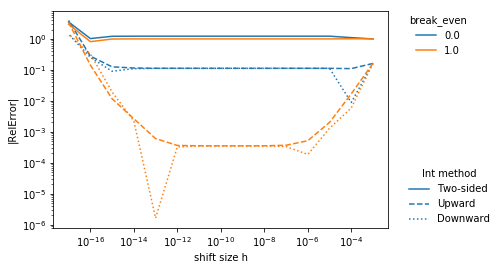

In [10]:
plotRelativeError2(table_simpson,'I',leg1 = 'break_even')

Plot for different number of grid points:

In [11]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2(SimpsonIntegration,n_grid_points=[i for i in range(11,301,10)],lambda_std_devs=[5], hs = [10**(-14)])

43.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


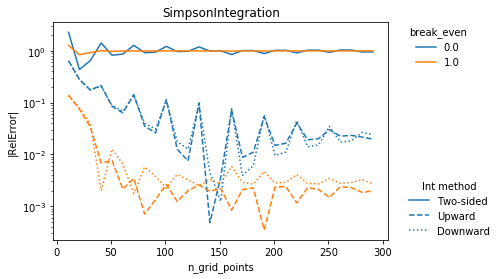

In [12]:
plotRelativeError2(
    table_simpson,'I',
    leg1='break_even',leg2=None,title='SimpsonIntegration',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    x_log_scale=False
)

Plots for different $\lambda$s.

In [89]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2(SimpsonIntegration,n_grid_points=[101],lambda_std_devs=[i for i in np.arange(0.5,10,0.5)], hs = [10**(-10)])

24.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


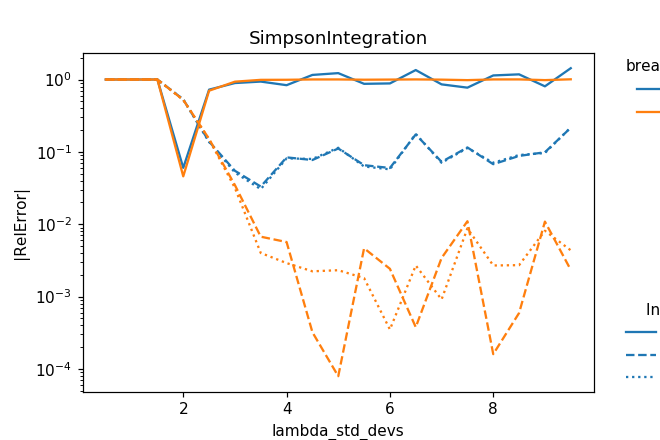

In [90]:
plotRelativeError2(
    table_simpson,'I',
    leg1='break_even',leg2=None,title='SimpsonIntegration',
    x_axis='lambda_std_devs',x_axis_label='lambda_std_devs',
    x_log_scale=False
)

Plot for different number of grid points and $\lambda$s. 

In [13]:
%%timeit -r 1
%%capture
table_simpson = compute_integration2(SimpsonIntegration,n_grid_points=[i for i in range(11,301,10)],
                                     lambda_std_devs=[2.5,5,7.5,10], 
                                     hs = [10**(-11)],non_break_even=False)

2min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


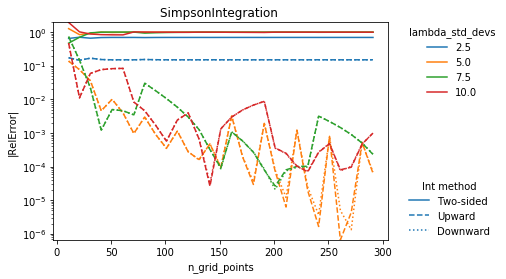

In [14]:
plotRelativeError2(
    table_simpson,'I',
    leg1='lambda_std_devs',leg2=None,title='SimpsonIntegration ',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    ylim=range_rel_error(table_simpson),
    x_log_scale=False
)

### 6.2 (c) Cubic Splice

In [9]:
%%timeit -r 1
%%capture
table= compute_integration2(CubicSplineExactIntegration,n_grid_points=[101],lambda_std_devs=[5], hs = [10**(-i) for i in range(3,18)])

19.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


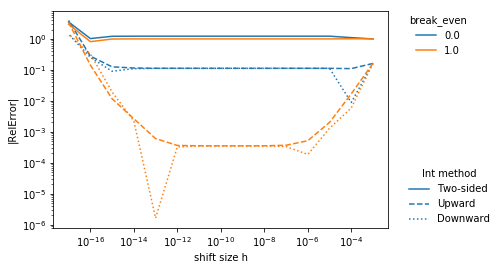

In [10]:
plotRelativeError2(table,'I',leg1 = 'break_even')

Plot for different number of grid points:

In [11]:
%%timeit -r 1
%%capture
table = compute_integration2(CubicSplineExactIntegration,n_grid_points=[i for i in range(11,301,10)],lambda_std_devs=[5], hs = [10**(-14)])

43.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


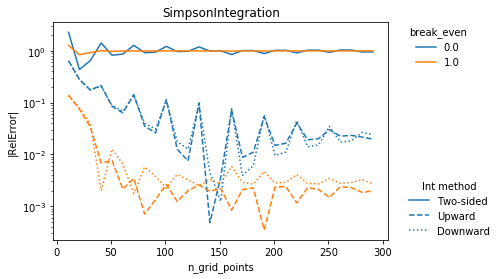

In [12]:
plotRelativeError2(
    table,'I',
    leg1='break_even',leg2=None,title='Cubic Spline Integration',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    x_log_scale=False
)

Plots for different $\lambda$s.

In [89]:
%%timeit -r 1
%%capture
table = compute_integration2(CubicSplineExactIntegration,n_grid_points=[101],lambda_std_devs=[i for i in np.arange(0.5,10,0.5)], hs = [10**(-14)])

24.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<IPython.core.display.Javascript object>


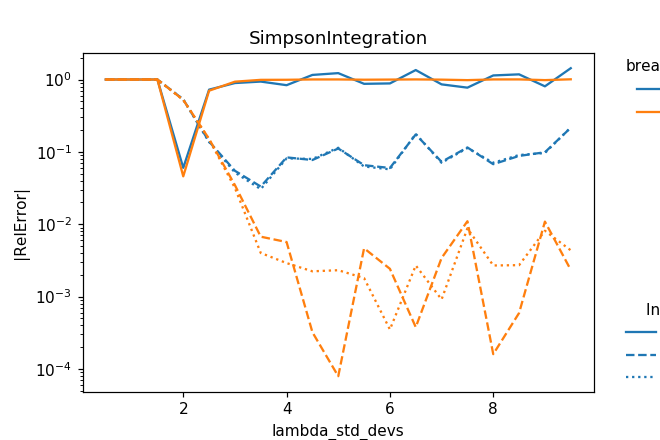

In [90]:
plotRelativeError2(
    table,'I',
    leg1='break_even',leg2=None,title='Cubic Spline Integration',
    x_axis='lambda_std_devs',x_axis_label='lambda_std_devs',
    x_log_scale=False
)

Plot for different number of grid points and $\lambda$s. 

In [ ]:
%%timeit -r 1
%%capture
table = compute_integration2(CubicSplineExactIntegration,n_grid_points=[i for i in range(11,301,10)],
                                     lambda_std_devs=[2.5,5,7.5,10], 
                                     hs = [10**(-11)],non_break_even=False)

In [ ]:
plotRelativeError2(
    table,'I',
    leg1='lambda_std_devs',leg2=None,title='Cubic Spline Integration ',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    ylim=range_rel_error(table_simpson),
    x_log_scale=False
)

### 6.2 (b) Hermite integration

In [16]:
%%timeit -r 1
%%capture
table = compute_integration2(HermiteIntegration,n_grid_points=[101],lambda_std_devs=[5], hs = [10**(-i) for i in range(3,18)], degree = 3)

17.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


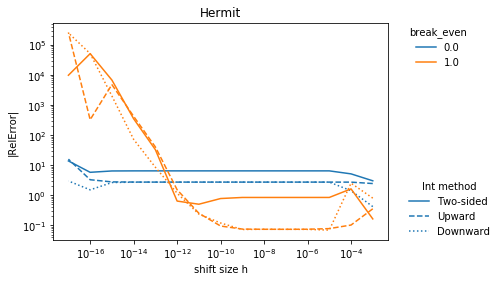

In [18]:
plotRelativeError2(table,'I',leg1 = 'break_even',title='Hermit')

Plot for different number of degrees:

In [36]:
%%timeit -r 1
%%capture
table,_ = compute_integration2_multiple(n_grid_points=[101],lambda_std_devs=[5], hs = [10**(-10)],
                                      degree=[i for i in range(1,11,1)],methods=[HermiteIntegration])

16.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


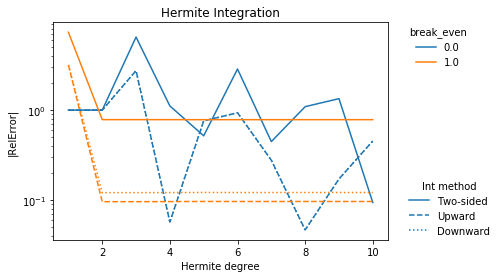

In [45]:
plotRelativeError2(
    table,'I',
    leg1='break_even',leg2=None,title='Hermite Integration',
    x_axis='degree',x_axis_label='Hermite degree',
    x_log_scale=False
)

Plot for different number of grid points.

In [51]:
%%timeit -r 1
%%capture
table,_ = compute_integration2_multiple(n_grid_points=[i for i in range(11,301,10)],lambda_std_devs=[5], hs = [10**(-10)],
                                      degree=[1,2,3],methods=[HermiteIntegration])

2min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
plotRelativeError2(
    table,'I',
    leg1='degree',leg2='break_even',title='Hermite Integration',
    integration_method=['Upward'],
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    x_log_scale=False
)

Plot for different number of grid points and $\lambda$s. 

### 6.2 (d) Hermite integration

In [35]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    n_grid_points=[101],
    lambda_std_devs=[5], hs = [10**(-i) for i in range(3,18)],
    degree=[1,2]
)

2min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


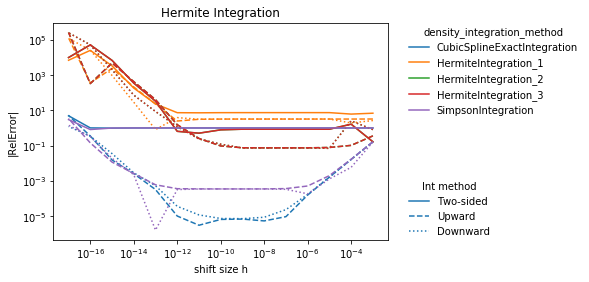

In [38]:
idx = table['density_integration_method'] == 'HermiteIntegration'
table.loc[idx,'density_integration_method'] = table.loc[idx,'density_integration_method'] + '_' + table.loc[idx,'degree'].map(str)
plotRelativeError2(
    table.query('break_even==1'),'I',
    leg1='density_integration_method',leg2=None,title='Integration'
)

/home/ms/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-08, right=1e-08
  'left=%s, right=%s') % (left, right))


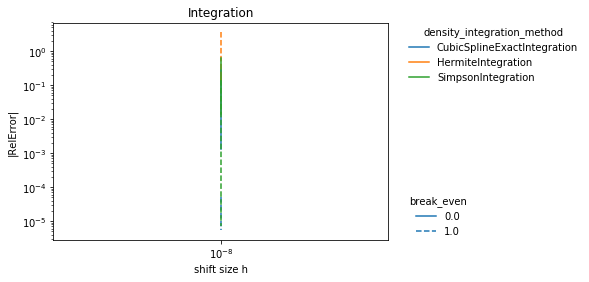

In [41]:
plotRelativeError2(
    table,'I',
    leg1='density_integration_method',leg2='break_even',title='Integration',
    integration_method='Upward'
)

In [39]:
time_table.round({'comp_time':4}).head()

,method,degree,comp_time
0,SimpsonIntegration,NaN,27.3898
1,CubicSplineExactIntegration,NaN,28.3894
2,HermiteIntegration,1.0,25.9896
3,HermiteIntegration,2.0,26.6189
4,HermiteIntegration,3.0,25.9400


In [9]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    n_grid_points=[i for i in range(11,301,10)],
    lambda_std_devs=[2.5,5,10], hs = [10**(-8)],
    degree=[2]
)

32.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


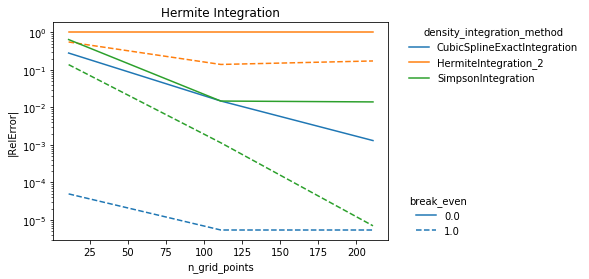

In [10]:
idx = table['density_integration_method'] == 'HermiteIntegration'
table.loc[idx,'density_integration_method'] = table.loc[idx,'density_integration_method'] + '_' + table.loc[idx,'degree'].map(str)
plotRelativeError2(
    table.query('lambda_std_devs==5'),'I',
    leg1='density_integration_method',leg2='break_even',title='Hermite Integration',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    integration_method='Upward',
    x_log_scale=False
)

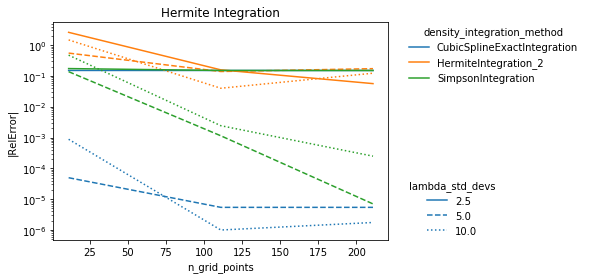

In [12]:
plotRelativeError2(
    table.query('break_even==1'),'I',
    leg1='density_integration_method',leg2='lambda_std_devs',title='Hermite Integration',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    integration_method='Upward',
    x_log_scale=False
)

In [13]:
time_table.round({'comp_time':4}).head()

,method,degree,comp_time
0,SimpsonIntegration,NaN,11.5375
1,CubicSplineExactIntegration,NaN,11.1352
2,HermiteIntegration,2.0,9.9831


### 6.3 (a)

Plot for different $\lambda$s.

In [14]:
%%timeit -r 1
%%capture
table = compute_integration2(
    PDESolver,
    lambda_std_devs=[2.5,5,10],
    break_even=False
)

54.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


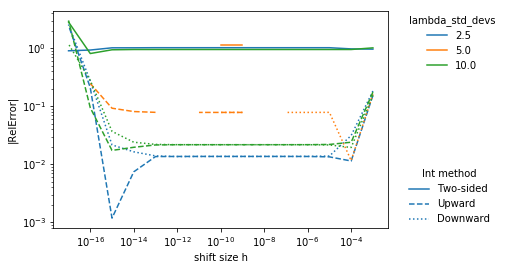

In [15]:
plotRelativeError2(
    table,'I',
    leg1='lambda_std_devs',
    title='PDESolver'
)

Plot for different number of grid points.

In [17]:
%%timeit -r 1
%%capture
table = compute_integration2(
    PDESolver,
    lambda_std_devs=[2.5,5,10],
    n_grid_points=[i for i in range(11,301,10)],
    hs=[10**(-10)],
    break_even=False
)

2min ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


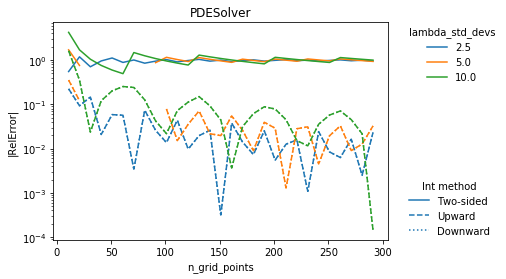

In [22]:
plotRelativeError2(
    table,'I',
    leg1='lambda_std_devs',leg2=None,title='PDESolver',
    x_axis='n_grid_points',x_axis_label='n_grid_points',
    x_log_scale=False
)

Plot for different time step size and $\lambda$s.

In [20]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    lambda_std_devs=[2.5,5,10],
    n_grid_points=[151],
    hs=[10**(-10)],
    timeStepSize=[i/24 for i in range(1,48,3)],
    break_even=False,
    methods=[PDESolver]
)

46.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


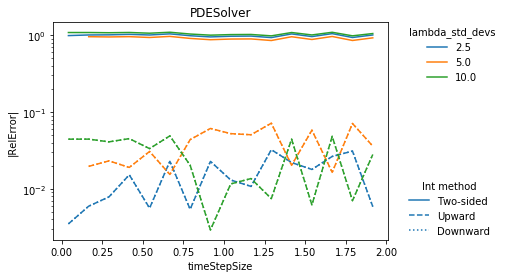

In [21]:
plotRelativeError2(
    table,'I',
    leg1='lambda_std_devs',leg2=None,title='PDESolver',
    x_axis='timeStepSize',x_axis_label='timeStepSize',
    x_log_scale=False
)

Plot for different time step size and number of grid points.

In [22]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    lambda_std_devs=[2.5],
    n_grid_points=[51,101,201],
    hs=[10**(-10)],
    timeStepSize=[i/12/2 for i in range(1,48,2)],
    break_even=False,
    methods=[PDESolver]
)

45.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


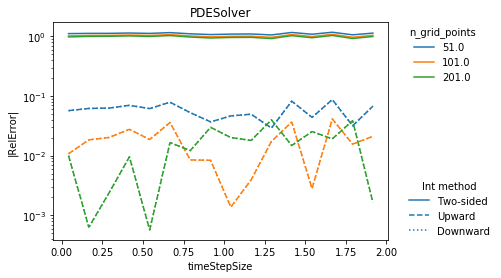

In [24]:
plotRelativeError2(
    table,'I',
    leg1='n_grid_points',leg2=None,title='PDESolver',
    x_axis='timeStepSize',x_axis_label='timeStepSize',
    x_log_scale=False
)

Plot for different $\theta$ 

In [31]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    lambda_std_devs=[2.5],
    n_grid_points=[101],
    hs=[10**(-10)],
    theta=[i/10 for i in range(3,11,1)],
    break_even=False,
    methods=[PDESolver]
)

12.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


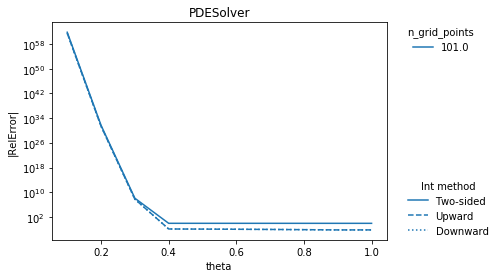

In [33]:
plotRelativeError2(
    table,'I',
    leg1='n_grid_points',leg2=None,title='PDESolver',
    x_axis='theta',x_axis_label='theta',
    x_log_scale=False
)

Plot boundary condition versus grid size.

In [10]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    lambda_std_devs=[i for i in np.arange(2,10,1)],
    n_grid_points=[101],
    hs=[10**(-10)],
    break_even=False,
    methods=[PDESolver],
    lambda0N=[None,0,1]
)

30.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


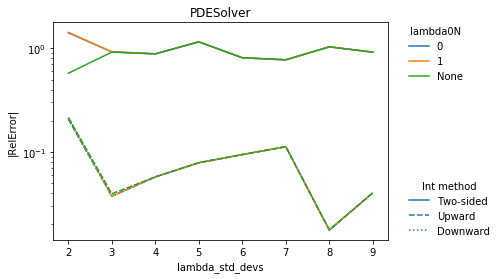

In [12]:
table['lambda0N'] = table['lambda0N'].map(str)
plotRelativeError2(
    table,'I',
    leg1='lambda0N',leg2=None,title='PDESolver',
    x_axis='lambda_std_devs',x_axis_label='lambda_std_devs',
    x_log_scale=False
)

In [ ]:
%%timeit -r 1
%%capture
table,time_table = compute_integration2_multiple(
    lambda_std_devs=[2.5,5,10],
    n_grid_points=[101],
    hs=[10**(-i) for i in range(3,18)],
    break_even=False,
    methods=[PDESolver],
    lambda0N=[None,0]
)

In [ ]:
table['lambda0N'] = table['lambda0N'].map(str)
plotRelativeError2(
    table,'I',
    leg1='lambda0N',leg2=None,title='PDESolver'
)